# Effects of  attention on Covid analysis

Now we know that influential people talked about Covid and that the general population did express interest in this topic. However, we notice there exists a difference between the levels of attention on Covid between countries: For some countries, this attention from both the general public and influential people is very high, while for some others, it is significantly lower. Hence, we would like to examine if countries' attention to the Covid had certain effect on the percentage of people infected with coronavirus. Did high attnetion towards Covid in early stages of pandemic help people fight it, or was it simply a sign that a country immediatly faced a difficult situation when the virus first started spreading?  

The initial idea of this part is to quantify the overall interest in Covid (e.g, on Wikipedia) and its presence in social media (e.g., Twitter) in the period that preceded the official lockdowns (or any other similar measure, e.g., school closure or ban of the public events", for countries that did not impose the official lockdowns) through a measure we call the attention score. Then we compare the number of Covid infections between some similar countries with different attention scores and try to draw conclusions based on the results we get.

The period we take into account when we compute the attention score is the same as in the previous parts: 3 weeks before the lockdown starts in each country, as during this period Covid spread reached its peak across countries, so we want to inspect how influential people and general public's attention on Covid help (or not?) country fight pandemic when, in essence, this was the only way to set people behavior, e.g., staying at home, avoiding social contacts, before this behavior was imposed by governments.  

Furthermore, to compare the number of Covid infections, we use 45 days since the start of the lockdown in each respective country, comparing the number of new infections per day for each of them. We chose this interval as the effects of Covid’s spread, people’s behavior, and attention given to Covid during the pre-lockdown term are most visible at the beginning of the lockdown when coronavirus reaches its peak before lockdown mitigates its spread. On the other hand, we want to be careful about the length of the period we use for comparison. If it is too long, the influences of various confounders could strongly impact the results, e.g., the strictness of the government measures, competence of the countries when handling crises situations, etc. 

The pipeline in this notebook includes:
1. Computing the `covid attention score` for each country
2. Create a new dataset describing each county, their policies, and general situation during the first wave of the pandemic
3. Add number of infections for each country per day for period of 45 days starting on the first day of the lockdown 
4. Match up countries with different `covid attention score` based on their similarities 
5. Apply paired t-test and compute CI between series of daily Covid infections of countries in the pair in order to check if there exists statistical evidence that the mean differnece is different from zero

In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import re
import json
import string
from datetime import datetime, timedelta

import translators as ts

import networkx as nx
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression

# Natural language processing libraries
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Twitter library
import tweepy

# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Topic analysis libraries
import pyLDAvis 
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
import pyLDAvis.gensim_models as gensimvi

import gensim
from gensim import corpora
import pickle
import bz2
import json

import warnings
warnings.filterwarnings("ignore")

import spacy
%matplotlib inline

Using state Belgrade server backend.
C:\Users\Korisnik\anaconda3\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
C:\Users\Korisnik\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


## 1. Covid attention score

When computing the `covid attention score` for each country, we rely on two sources:
1. Twitter data of influential people - represents the presence of Covid in the media
2. Wikipedia pageviews - represent the people's general interest in Covid

To determine the key topics talked about by influential people on Twitter, we utilize the Linear discriminant analysis (LDA). We minimize the perplexity score given by the LDA to find out how many and what topics were discussed by influential people from each country. Thus, we can recognize a topic that is related to the pandemic, Covid, lockdown, etc., and compute the percentage of tokens associated with this topic. This percentage is the score we use to quantify the presence of Covid on social media for each country.

Next, we use the `aggregated_timeseries.json` dataset to get the average percentage of pageviews going to covid-related pages per day for pages in the appropriate language for the country we analyze.

Finally, to compute the Covid attention score, we find the harmonic mean between the score obtained by LDA and the average Wikipedia covid pageview score. We use the harmonic mean to evenly weigh the influence of each of the percentage scores applied. For example, 1% of pageviews to covid-related pages represent a very significant interest in Covid compared to the number of topics available on Wikipedia. On the other hand, the number of topics we can explore by topic analysis is many orders of magnitude smaller, so significant attention to Covid is characterized by a larger percentage. 

### Load data

In [2]:
# twitter data for influential people
influential_people_tweets = pd.read_csv('output/influential_people_tweets.csv', delimiter=',')
influential_people_tweets.head()

,id,country_code,lang,user,tweet_text_orginal,tweet_text_en,tweet_date,context_annotations
0,1234249601517047814,RS,sr,Response(data=<User id=356450858 name=Александ...,Хвала @AIPAC на изузетној части да говорим на ...,thanks on an exceptional honor to speak at the...,2020-03-01 22:50:10+00:00,"[{'domain': {'id': '45', 'name': 'Brand Vertic..."
1,1234183480625553410,RS,sr,Response(data=<User id=205153283 name=Dragan D...,"Ovakvih snimaka, kao ni onih kada ih izbacuju ...",several recordings like no ones when they thro...,2020-03-01 18:27:26+00:00,[]
2,1234196504123969536,RS,sr,Response(data=<User id=834073582514888710 name...,"Da li stel primetili suptilnu, ali vrlo podmuk...",did stel noticed a subtle but very insidious s...,2020-03-01 19:19:11+00:00,[]
3,1234253894244536323,RS,sr,Response(data=<User id=181338564 name=Marija S...,Safe trip girls🎉 #Hurricane,safe trip girls #hurricane,2020-03-01 23:07:14+00:00,[]
4,1234252303810600961,RS,sr,Response(data=<User id=181338564 name=Marija S...,Jebote jel su ljudi zaboravili da se raduju ????,fuck did people forget that they are looking f...,2020-03-01 23:00:55+00:00,[]


In [3]:
# json data of aggregated time-series of wikipedia pageviews
json_file_path = "data/aggregated_timeseries.json"
with open(json_file_path, 'r') as j:
     aggregated_timeseries = json.loads(j.read())

Let's show countries that we analyze in this notebook.

In [4]:
influential_people_tweets['country_code'].value_counts().index

Index(['IT', 'CA', 'JA', 'FI', 'NL', 'FR', 'NO', 'DK', 'RS', 'DE', 'SE', 'KO'], dtype='object')

As we can see from the results above there are 12 diffrent countries from which we will look at the tweets from influencial people. They are:

1. IT - Italy
2. CA - Canada
3. JA - Japan
4. FI - Finland
5. FR - France
6. DE - Germany
7. SE - Sweden
8. NO - Norway
9. DK - Denmark
10. KO - Korea
11. NL - Netherlands
12. RS - Serbia

For calculating the presence of covid related tweets we use topics modeling and a function which creates LDA model explained in notebook related to RQ2.

In [5]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    # Initialize spaCy 'en' model, keeping only tagger component (for efficiency)
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# constructing pair of words
def make_bigrams(texts, bigram_mod):
    return [bigram_mod[doc] for doc in texts]

# constructing set of three words
def make_trigrams(texts, bigram_mod, trigram_mod):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [6]:
# function for creating LDA model
def createLDAModel(influential_people_tweets, country_code, number_topics):
    """
    Function which creates LDA model 
    
    Arguments:
        influential_people_tweets: dataset which contains tweets from influential people
        country_code: country for which we are creating model 
        number_topics: number of topics 
    """
    tweets_from_country = influential_people_tweets.loc[influential_people_tweets['country_code']==country_code, 
                                                            'tweet_text_en']

    data_words = []
    for row in tweets_from_country:
        data_words.append(str(row).split())

    #print("Words example\n", data_words[:1])

    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    # See trigram example
    #print("\nTrigram example\n", trigram_mod[bigram_mod[data_words[0]]])

    data_words_bigrams = make_bigrams(data_words, bigram_mod)

    # Perform lemmatization keeping noun, adjective, verb, and adverb
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN']) #, 'ADJ', 'VERB', 'ADV'

    #print("\nData lemmatization\n", data_lemmatized[:1])

    id2word = corpora.Dictionary(data_lemmatized)

    # Create Corpus
    texts = data_lemmatized

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]

    # Create a LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=number_topics, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=5,
                                               passes=10,
                                               alpha='auto',
                                               eval_every=5, 
                                               per_word_topics=True)

    doc_lda = lda_model[corpus]

    # Compute Perplexity
    print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

    pyLDAvis.enable_notebook()
    visualization = gensimvi.prepare(lda_model, corpus, id2word)
    return visualization

For calculating the percentage of pageviews going to covid-related pages per day for pages, we use the following function.

In [7]:
def get_percetage_wikiviews(country_code, start, end):
    # We get the dates belonging to the 3-week period before the lockdown starts in Italy 
    dates = [date for date in pd.to_datetime(
        list(aggregated_timeseries[country_code + ".m"]["covid"]["sum"].keys()))  if date >= start]

    dates = [date for date in dates if date <= end]
    
    # Get the percentage of visits to covid-related pages for each day with respect to the total number of visits to Wikipedia pages 
    # for both mobile and desktop devices.
    covid_visits = pd.Series(
        [(aggregated_timeseries[country_code + ".m"]["covid"]["sum"][str(key)] + aggregated_timeseries[
            country_code]["covid"]["sum"][str(key)]) / (aggregated_timeseries[
            country_code + ".m"]["sum"][str(key)] + aggregated_timeseries["it"]["sum"][str(key)]) for key in dates])
    
    print(covid_visits.describe())
    return covid_visits.mean()

### Covid attention score Italy

In [8]:
visualization = createLDAModel(influential_people_tweets, 'IT', 4)
pyLDAvis.save_html(visualization, 'LDA_IT.html')
visualization


Perplexity:  -9.100461513491963


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.100379  0.092067       1        1  27.306358
1      0.004211 -0.043637       2        1  25.522652
0      0.019554 -0.104874       3        1  23.695982
3     -0.124144  0.056444       4        1  23.475008, topic_info=             Term        Freq       Total Category  logprob  loglift
27          today  243.000000  243.000000  Default  30.0000  30.0000
770       measure  243.000000  243.000000  Default  29.0000  29.0000
627     emergency  236.000000  236.000000  Default  28.0000  28.0000
380   coronavirus  187.000000  187.000000  Default  27.0000  27.0000
109         photo  157.000000  157.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
3168     dialogue   28.874635  134.483877   Topic4  -4.9429  -0.0892
2236       sinner   26.719575  118.622567   Topic4  -5.0205  -0.0413
1989         snow   26.701730  118.687671   Topic4  -5.0211  -0.0425
856     lombardia   26.325167  117.097444   Topic4  -5.0353  -0.0432
86       prisoner   21.552533   90.393472   Topic4  -5.2354   0.0156

[185 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
281       2  0.991873         #
398       1  0.823230  accident
398       2  0.048425  accident
398       3  0.048425  accident
398       4  0.048425  accident
...     ...       ...       ...
82        4  0.945928      word
9         2  0.991820      work
352       1  0.969123    worker
394       4  0.984742     world
39        3  0.991700      year

[257 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4])

From visualization we can see (might not visible from git as it is interactive visualization) that the topic 1 is related to the covid and it contains 27.3% of tokens, which means that we can estimate that around 27.3% of discussions are Covid-related.

Let us now find the average percetage of pageviews going to covid-related pages per day for pages for Italy.

In [9]:
# start of the observation period: 3 weeks before lockdown
start = datetime(2020, 2, 19)
# end of the observation period: lockdown begins
end = datetime(2020, 3, 10)
views_it = get_percetage_wikiviews("it", start, end)

count    21.000000
mean      0.002502
std       0.001567
min       0.000243
25%       0.001370
50%       0.002135
75%       0.003451
max       0.006197
dtype: float64


Let's find the Covid attention score based on the formula we described before.

In [10]:
attention = {"Italy": 2 * views_it * 0.273 / (views_it + 0.273)}
print("Covid attention score for Italy:", attention["Italy"])

Covid attention score for Italy: 0.004959528316860655


### Covid attention score Serbia

In [11]:
visualization = createLDAModel(influential_people_tweets, 'RS', 4)
pyLDAvis.save_html(visualization, 'LDA_RS.html')
visualization


Perplexity:  -9.155322812903819


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.124684  0.013303       1        1  35.676162
3     -0.060900  0.071652       2        1  26.067252
2     -0.030024 -0.043655       3        1  20.021246
0     -0.033760 -0.041300       4        1  18.235340, topic_info=           Term        Freq       Total Category  logprob  loglift
3        people  120.000000  120.000000  Default  30.0000  30.0000
48        state   78.000000   78.000000  Default  29.0000  29.0000
84         time   90.000000   90.000000  Default  28.0000  28.0000
27      tonight   36.000000   36.000000  Default  27.0000  27.0000
9           day   42.000000   42.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
1189       bank    5.923433   33.117954   Topic4  -5.1553  -0.0194
1329      logic    4.169293   20.331469   Topic4  -5.5065   0.1174
1352    network    4.335275   24.286666   Topic4  -5.4674  -0.0213
772        cafe    4.157247   23.996933   Topic4  -5.5094  -0.0513
376   emergency    4.075176   36.695404   Topic4  -5.5293  -0.4959

[244 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
264       1  0.581736    account
264       2  0.161593    account
264       3  0.129275    account
264       4  0.096956    account
1305      1  0.237169        act
...     ...       ...        ...
144       4  0.203122  đukanović
1964      1  0.251951          €
1964      2  0.251951          €
1964      3  0.251951          €
1964      4  0.201561          €

[435 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1])

From visualization we can see (might not visible from git as it is interactive visualization) that the topic 2 is related to the covid and it contains 26.1% of tokens. 

Let us now find the average percetage of pageviews going to covid-related pages per day for pages for Serbia.

In [12]:
# start of the observation period: 3 weeks before lockdown
start = datetime(2020, 2, 29)
# end of the observation period: lockdown begins
end = datetime(2020, 3, 20)
views_sr = get_percetage_wikiviews("sr", start, end)

count    21.000000
mean      0.000103
std       0.000105
min       0.000005
25%       0.000010
50%       0.000027
75%       0.000212
max       0.000261
dtype: float64


In [13]:
attention["Serbia"] = 2 * views_sr * 0.261 / (views_sr + 0.261)
print("Covid attention score for Serbia:", attention["Serbia"])

Covid attention score for Serbia: 0.00020648010693546405


### Covid attention score Canada

In [14]:
visualization = createLDAModel(influential_people_tweets, 'CA', 3)
pyLDAvis.save_html(visualization, 'LDA_CA.html')
visualization


Perplexity:  -9.071950412053365


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.107327  0.001591       1        1  42.871192
2     -0.051710 -0.066345       2        1  31.694291
0     -0.055617  0.064754       3        1  25.434517, topic_info=               Term        Freq       Total Category  logprob  loglift
231          travel  159.000000  159.000000  Default  30.0000  30.0000
134          market  207.000000  207.000000  Default  29.0000  29.0000
4       coronavirus  177.000000  177.000000  Default  28.0000  28.0000
32           health  118.000000  118.000000  Default  27.0000  27.0000
68             case  100.000000  100.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
894           value   12.678245   52.782380   Topic3  -5.7548  -0.0572
14       quarantine   15.334068   80.327269   Topic3  -5.5646  -0.2870
2724  selfisolation   11.789096   49.863580   Topic3  -5.8275  -0.0731
1078       employee   10.775591   42.697975   Topic3  -5.9174  -0.0078
941      retirement   11.530956   60.110120   Topic3  -5.8497  -0.2821

[179 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
653       1  0.987226         #
1214      1  0.371242  activist
1214      2  0.346493  activist
1214      3  0.272244  activist
79        1  0.919476  analysis
...     ...       ...       ...
19        1  0.892073    worker
19        2  0.059472    worker
19        3  0.059472    worker
78        1  0.988765     world
43        1  0.995610      year

[302 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

From visualization we can see (might not visible from git as it is interactive visualization) that the topic 1 is related to the covid and it contains 42.9% of tokens. 

Let us now find the average percetage of pageviews going to covid-related pages per day for pages for Canada.

In [15]:
# start of the observation period: 3 weeks before lockdown
start = datetime(2020, 2, 22)
# end of the observation period: lockdown begins
end = datetime(2020, 3, 13)
views_ca = get_percetage_wikiviews("ca", start, end)

count    21.000000
mean      0.000140
std       0.000091
min       0.000024
25%       0.000093
50%       0.000110
75%       0.000162
max       0.000362
dtype: float64


In [16]:
attention["Canada"] = 2 * views_ca * 0.429 / (views_ca + 0.429)
print("Covid attention score for Canada:", attention["Canada"])

Covid attention score for Canada: 0.0002807447767778885


### Covid attention score Japan

In [17]:
visualization = createLDAModel(influential_people_tweets, 'JA', 6)
pyLDAvis.save_html(visualization, 'LDA_JA.html')
visualization


Perplexity:  -8.378739021581895


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.295544  0.001402       1        1  34.451139
3     -0.055027 -0.231140       2        1  15.819579
4     -0.051147  0.121605       3        1  15.272848
1     -0.059491  0.039218       4        1  14.570716
2     -0.068622  0.048739       5        1  13.633147
0     -0.061258  0.020176       6        1   6.252571, topic_info=               Term        Freq       Total Category  logprob  loglift
2            nhknew  861.000000  861.000000  Default  30.0000  30.0000
52           number  304.000000  304.000000  Default  29.0000  29.0000
135       infection  527.000000  527.000000  Default  28.0000  28.0000
81             time  261.000000  261.000000  Default  27.0000  27.0000
8                 #  433.000000  433.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
42         property    5.104035   53.786767   Topic6  -5.4489   0.4172
1153            bar    9.102361  137.506166   Topic6  -4.8704   0.0570
2675           soul    4.009059   36.962742   Topic6  -5.6904   0.5508
894   entertainment    3.993645   40.862493   Topic6  -5.6943   0.4467
608           music    3.767306   35.825121   Topic6  -5.7526   0.5199

[273 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
8         1  0.997371          #
501       3  0.985558   activity
291       2  0.962820   addition
161       4  0.992144        app
656       4  0.954153        art
...     ...       ...        ...
1246      5  0.160642   yamagata
1246      6  0.128513   yamagata
36        2  0.992902       year
50        6  0.467062        yen
397       2  0.953249  yesterday

[468 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 4, 5, 2, 3, 1])

From visualization we can see (might not visible from git as it is interactive visualization) that the topic 1 is related to the covid and it contains 34.5% of tokens. 

Let us now find the average percetage of pageviews going to covid-related pages per day for pages for Japan.

In [18]:
# start of the observation period: 3 weeks before mobility drops
start = datetime(2020, 3, 10)
# end of the observation period: mobility drop begins
end = datetime(2020, 3, 30)
views_ja = get_percetage_wikiviews("ja", start, end)

count    21.000000
mean      0.002927
std       0.000477
min       0.002157
25%       0.002517
50%       0.002998
75%       0.003195
max       0.004060
dtype: float64


In [19]:
attention["Japan"] = 2 * views_ja * 0.345 / (views_ja + 0.345)
print("Covid attention score for Japan:", attention["Japan"])

Covid attention score for Japan: 0.005805692760968661


### Covid attention score Finland

In [20]:
visualization = createLDAModel(influential_people_tweets, 'FI', 4)
pyLDAvis.save_html(visualization, 'LDA_FI.html')
visualization


Perplexity:  -9.249128567169828


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.124788  0.069546       1        1  28.658600
1     -0.004312 -0.134521       2        1  26.811373
2      0.117964  0.069035       3        1  25.033492
0      0.011136 -0.004060       4        1  19.496535, topic_info=                Term        Freq       Total Category  logprob  loglift
955   reader_opinion  230.000000  230.000000  Default  30.0000  30.0000
331        infection  173.000000  173.000000  Default  29.0000  29.0000
200           school  155.000000  155.000000  Default  28.0000  28.0000
161             home  118.000000  118.000000  Default  27.0000  27.0000
93              time  148.000000  148.000000  Default  26.0000  26.0000
...              ...         ...         ...      ...      ...      ...
793        education   12.180720   79.467655   Topic4  -5.5561  -0.2406
1455       recycling    7.508892   31.238754   Topic4  -6.0399   0.2094
1661           novel    7.744271   39.170663   Topic4  -6.0090   0.0140
1683  recommendation    7.602296   39.114275   Topic4  -6.0275  -0.0031
1946         package    7.544105   38.800996   Topic4  -6.0352  -0.0027

[175 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1273      1  0.928451    action
40        1  0.925937  activity
40        2  0.040258  activity
40        3  0.040258  activity
40        4  0.040258  activity
...     ...       ...       ...
106       4  0.996028      week
227       3  0.966383     woman
278       1  0.994025      work
184       3  0.997403     world
125       2  0.992890      year

[224 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1])

From visualization we can see (might not visible from git as it is interactive visualization) that the topic 3 is related to the covid and it contains 25% of tokens. 

Let us now find the average percetage of pageviews going to covid-related pages per day for pages for Finland.

In [21]:
# start of the observation period: 3 weeks before mobility drops
start = datetime(2020, 2, 24)
# end of the observation period: mobility drop begins
end = datetime(2020, 3, 15)
views_fi = get_percetage_wikiviews("fi", start, end)

count    21.000000
mean      0.000981
std       0.000893
min       0.000366
25%       0.000460
50%       0.000602
75%       0.000821
max       0.003443
dtype: float64


In [22]:
attention["Finland"] = 2 * views_fi * 0.25 / (views_fi + 0.25)
print("Covid attention score for Finland:", attention["Finland"])

Covid attention score for Finland: 0.001953529487293006


### Covid attention score France

In [23]:
visualization = createLDAModel(influential_people_tweets, 'FR', 5)
pyLDAvis.save_html(visualization, 'LDA_FR.html')
visualization


Perplexity:  -9.696878085199007


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.183913  0.031263       1        1  29.219948
2      0.084250  0.146928       2        1  23.596230
0      0.044949 -0.098199       3        1  18.288953
4      0.024709 -0.034949       4        1  14.543532
1      0.030005 -0.045042       5        1  14.351337, topic_info=              Term        Freq       Total Category  logprob  loglift
53               #  315.000000  315.000000  Default  30.0000  30.0000
13     coronavirus  262.000000  262.000000  Default  29.0000  29.0000
468            day  104.000000  104.000000  Default  28.0000  28.0000
15        epidemic  145.000000  145.000000  Default  27.0000  27.0000
76              pm  103.000000  103.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
3170    accelerate    6.433789   37.255480   Topic5  -5.6719   0.1851
1628  announcement    6.868524   43.853456   Topic5  -5.6065   0.0874
520       pandemic    8.008496   75.258671   Topic5  -5.4529  -0.2991
11         morning    6.311050   37.033750   Topic5  -5.6912   0.1718
2255          noon    6.298260   37.049579   Topic5  -5.6932   0.1693

[241 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
53        2  0.997290           #
1420      1  0.241421  abstention
1420      2  0.206932  abstention
1420      3  0.189688  abstention
1420      4  0.189688  abstention
...     ...       ...         ...
873       4  0.045445        word
873       5  0.045445        word
144       1  0.986189        work
245       2  0.991229       world
52        2  0.975239        year

[387 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 5, 2])

From visualization we can see (might not visible from git as it is interactive visualization) that the topic 1 is related to the covid and it contains 29.2% of tokens. 

Let us now find the average percetage of pageviews going to covid-related pages per day for pages for France.

In [24]:
# start of the observation period: 3 weeks before lockdown
start = datetime(2020, 2, 25)
# end of the observation period: lockdown begins
end = datetime(2020, 3, 16)
views_fr = get_percetage_wikiviews("fr", start, end)

count    21.000000
mean      0.001186
std       0.000855
min       0.000510
25%       0.000659
50%       0.000739
75%       0.001122
max       0.002984
dtype: float64


In [25]:
attention["France"] = 2 * views_fr * 0.292 / (views_fr + 0.292)
print("Covid attention score for France:", attention["France"])

Covid attention score for France: 0.002363236779783313


### Covid attention score Germany

In [26]:
visualization = createLDAModel(influential_people_tweets, 'DE', 4)
pyLDAvis.save_html(visualization, 'LDA_DE.html')
visualization


Perplexity:  -8.497098291379663


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.150112  0.007267       1        1  41.829144
3     -0.062307  0.076976       2        1  24.317683
0     -0.042905 -0.038737       3        1  17.287047
2     -0.044900 -0.045506       4        1  16.566126, topic_info=             Term        Freq       Total Category  logprob  loglift
0               #  200.000000  200.000000  Default  30.0000  30.0000
5          crisis  121.000000  121.000000  Default  29.0000  29.0000
65         corona  180.000000  180.000000  Default  28.0000  28.0000
9      coronaviru  126.000000  126.000000  Default  27.0000  27.0000
61    coronavirus  119.000000  119.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
1034    thank_you    2.935910   17.461352   Topic4  -5.7473   0.0148
1649        mouth    2.654569   13.856288   Topic4  -5.8480   0.1454
1101   wirvsvirus    4.128564   48.681625   Topic4  -5.4064  -0.6696
754           tax    2.791587   16.251876   Topic4  -5.7977   0.0362
1131       parent    2.905930   19.706271   Topic4  -5.7575  -0.1164

[272 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.995833        #
922       1  0.672442   action
922       2  0.144095   action
922       3  0.096063   action
922       4  0.096063   action
...     ...       ...      ...
158       2  0.946441     year
1620      1  0.270396  youtube
1620      2  0.270396  youtube
1620      3  0.270396  youtube
1620      4  0.270396  youtube

[499 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 3])

From visualization we can see (might not visible from git as it is interactive visualization) that the topic 1 is related to the covid and it contains 41.8% of tokens. 

Let us now find the average percetage of pageviews going to covid-related pages per day for pages for Germany.

In [27]:
# start of the observation period: 3 weeks before lockdown
start = datetime(2020, 3, 1)
# end of the observation period: lockdown begins
end = datetime(2020, 3, 21)
views_de = get_percetage_wikiviews("de", start, end)

count    21.000000
mean      0.008865
std       0.007936
min       0.001223
25%       0.001948
50%       0.002963
75%       0.015895
max       0.023933
dtype: float64


In [28]:
attention["Germany"] = 2 * views_de * 0.418 / (views_de + 0.418)
print("Covid attention score for Germany:", attention["Germany"])

Covid attention score for Germany: 0.017361740045669257


### Covid attention score Sweden

In [29]:
visualization = createLDAModel(influential_people_tweets, 'SE', 5)
pyLDAvis.save_html(visualization, 'LDA_SE.html')
visualization


Perplexity:  -9.46049979205268


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.018098  0.010327       1        1  24.340500
1      0.073276 -0.099723       2        1  21.205418
3     -0.135718 -0.025959       3        1  21.174473
0      0.034566  0.099621       4        1  18.643562
4      0.009778  0.015733       5        1  14.636047, topic_info=            Term       Freq      Total Category  logprob  loglift
30         thing  92.000000  92.000000  Default  30.0000  30.0000
307       corona  88.000000  88.000000  Default  29.0000  29.0000
231       leader  63.000000  63.000000  Default  28.0000  28.0000
434      meeting  63.000000  63.000000  Default  27.0000  27.0000
656    authority  52.000000  52.000000  Default  26.0000  26.0000
...          ...        ...        ...      ...      ...      ...
172          law   3.634101  35.100116   Topic5  -5.4111  -0.3462
113   profession   2.903054  17.244343   Topic5  -5.6357   0.1400
1599     housing   3.012038  22.054104   Topic5  -5.5989  -0.0692
317      reading   2.898585  17.207505   Topic5  -5.6373   0.1406
1493     caution   2.915055  19.334129   Topic5  -5.6316   0.0297

[276 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
504       1  0.831981  accident
505       5  0.706013       act
99        4  0.991023    action
838       1  0.309426    agency
838       2  0.154713    agency
...     ...       ...       ...
1722      1  0.311478    yetlag
1722      2  0.155739    yetlag
1722      3  0.155739    yetlag
1722      4  0.155739    yetlag
1722      5  0.155739    yetlag

[463 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 1, 5])

From visualization we can see (might not visible from git as it is interactive visualization) that the topic 4 is related to the covid and it contains 18.6% of tokens. 

Let us now find the average percetage of pageviews going to covid-related pages per day for pages for Sweden.

In [30]:
# start of the observation period: 3 weeks before mobility drops
start = datetime(2020, 2, 19)
# end of the observation period: mobility drop begins
end = datetime(2020, 3, 10)
views_sv = get_percetage_wikiviews("sv", start, end)

count    21.000000
mean      0.000005
std       0.000005
min       0.000002
25%       0.000003
50%       0.000004
75%       0.000005
max       0.000023
dtype: float64


In [31]:
attention["Sweden"] = 2 * views_sv * 0.186 / (views_sv + 0.186)
print("Covid attention score for Sweden:", attention["Sweden"])

Covid attention score for Sweden: 1.0648297019484119e-05


### Covid attention score Norway

In [32]:
visualization = createLDAModel(influential_people_tweets, 'NO', 6)
pyLDAvis.save_html(visualization, 'LDA_NO.html')
visualization


Perplexity:  -9.9990165254872


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.154444  0.007129       1        1  20.782579
1      0.049041  0.125836       2        1  19.342587
5      0.027476 -0.020734       3        1  18.746053
0      0.005488 -0.002637       4        1  17.958002
4      0.024563 -0.032640       5        1  14.402589
3      0.047876 -0.076954       6        1   8.768190, topic_info=             Term        Freq       Total Category  logprob  loglift
396        corona  170.000000  170.000000  Default  30.0000  30.0000
122        people  153.000000  153.000000  Default  29.0000  29.0000
175        crisis   90.000000   90.000000  Default  28.0000  28.0000
809          site   85.000000   85.000000  Default  27.0000  27.0000
423        person   91.000000   91.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
610      tomorrow    2.380133   23.395766   Topic6  -5.8374   0.1486
1943         skin    2.597426   28.594786   Topic6  -5.7501   0.0353
1189   researcher    2.803102   36.656856   Topic6  -5.6739  -0.1368
2313     exposure    2.357097   25.804463   Topic6  -5.8472   0.0409
469   description    2.059572   21.190206   Topic6  -5.9821   0.1030

[358 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         4  0.982541        #
854       1  0.194117   advice
854       2  0.194117   advice
854       3  0.194117   advice
854       4  0.194117   advice
...     ...       ...      ...
1125      3  0.818182  witness
363       3  0.952558    woman
151       3  0.830263     work
4         4  0.959794    world
71        5  0.974698     year

[734 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 6, 1, 5, 4])

From visualization we can see (might not visible from git as it is interactive visualization) that the topic 1 is related to the covid and it contains 20.8% of tokens. 

Let us now find the average percetage of pageviews going to covid-related pages per day for pages for Norway.

In [33]:
# start of the observation period: 3 weeks before lockdown
start = datetime(2020, 3, 3)
# end of the observation period: lockdown begins
end = datetime(2020, 3, 23)
views_no = get_percetage_wikiviews("no", start, end)

count    21.000000
mean      0.000413
std       0.000188
min       0.000176
25%       0.000273
50%       0.000399
75%       0.000471
max       0.000848
dtype: float64


In [34]:
attention["Norway"] = 2 * views_no * 0.208 / (views_no + 0.208)
print("Covid attention score for Norway:", attention["Norway"])

Covid attention score for Norway: 0.0008244653522084111


### Covid attention score Denmark

In [35]:
visualization = createLDAModel(influential_people_tweets, 'DK', 5)
pyLDAvis.save_html(visualization, 'LDA_DK.html')
visualization


Perplexity:  -9.76077631003266


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.148790  0.002476       1        1  29.142616
3     -0.038747 -0.079825       2        1  22.456021
4     -0.044367  0.081206       3        1  20.447214
2     -0.037971 -0.003364       4        1  16.211490
0     -0.027705 -0.000494       5        1  11.742660, topic_info=             Term        Freq       Total Category  logprob  loglift
66           dane  143.000000  143.000000  Default  30.0000  30.0000
69         people   63.000000   63.000000  Default  29.0000  29.0000
362        border   50.000000   50.000000  Default  28.0000  28.0000
252        corona   63.000000   63.000000  Default  27.0000  27.0000
255           son   36.000000   36.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
1186          can    2.961515   20.805690   Topic5  -5.3757   0.1924
799   supermarket    3.721021   30.701997   Topic5  -5.1474   0.0316
1105      hamster    3.069090   22.429390   Topic5  -5.3400   0.1530
1736      witness    2.299617   13.926236   Topic5  -5.6287   0.3409
523   consumption    2.292152   13.928863   Topic5  -5.6319   0.3375

[306 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
398       1  0.087084     action
398       2  0.087084     action
398       4  0.870844     action
536       1  0.957336  agreement
1272      1  0.382685   aircraft
...     ...       ...        ...
1736      5  0.143614    witness
445       2  0.959708      woman
199       1  0.776161       work
161       2  0.934987      world
137       2  0.978736       year

[567 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 5, 3, 1])

From visualization we can see (might not visible from git as it is interactive visualization) that the topic 1 is related to the covid and it contains 29.1% of tokens. 

Let us now find the average percetage of pageviews going to covid-related pages per day for pages for Denmark.

In [36]:
# start of the observation period: 3 weeks before lockdown
start = datetime(2020, 2, 26)
# end of the observation period: lockdown begins
end = datetime(2020, 3, 17)
views_da = get_percetage_wikiviews("da", start, end)

count    21.000000
mean      0.000332
std       0.000197
min       0.000118
25%       0.000170
50%       0.000287
75%       0.000501
max       0.000675
dtype: float64


In [37]:
attention["Denmark"] = 2 * views_da * 0.291 / (views_da + 0.291)
print("Covid attention score for Denmark:", attention["Denmark"])

Covid attention score for Denmark: 0.0006638651510874867


### Covid attention score Korea

In [38]:
visualization = createLDAModel(influential_people_tweets, 'KO', 9)
pyLDAvis.save_html(visualization, 'LDA_KO.html')
visualization


Perplexity:  -11.13407679919074


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.307536  0.152036       1        1  28.050139
0     -0.125539 -0.266365       2        1  13.078331
5     -0.013320 -0.037242       3        1  11.024967
7      0.037998  0.011222       4        1  10.010661
6      0.057460  0.016594       5        1   8.629817
2      0.105969  0.048534       6        1   8.602144
4      0.072186  0.027886       7        1   8.440978
3      0.078912  0.010569       8        1   6.258486
8      0.093871  0.036766       9        1   5.904477, topic_info=               Term        Freq       Total Category  logprob  loglift
16                #  527.000000  527.000000  Default  30.0000  30.0000
677         youtube   86.000000   86.000000  Default  29.0000  29.0000
945            idol   52.000000   52.000000  Default  28.0000  28.0000
872        treasure   93.000000   93.000000  Default  27.0000  27.0000
558             boy   43.000000   43.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
1373           note    1.460771   32.034424   Topic9  -5.3493  -0.2584
1489           form    1.439034   50.594675   Topic9  -5.3643  -0.7304
1524           aizu    1.007264   24.817444   Topic9  -5.7211  -0.3748
1562        charity    0.805639    3.855142   Topic9  -5.9444   1.2639
1557  dancingrookie    0.817846   23.609196   Topic9  -5.9294  -0.5333

[390 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
16        1  0.997748        #
1549      3  0.276265   agency
1549      6  0.276265   agency
1549      8  0.276265   agency
1524      1  0.080588     aizu
...     ...       ...      ...
1401      1  0.812760       yg
1401      2  0.078654       yg
1401      3  0.052436       yg
1401      4  0.026218       yg
677       2  0.988811  youtube

[672 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 6, 8, 7, 3, 5, 4, 9])

From visualization we can see (might not visible from git as it is interactive visualization) that the topic 5 is related to the covid and it contains 8.6% of tokens. 

Let us now find the average percetage of pageviews going to covid-related pages per day for pages for Korea.

In [39]:
# start of the observation period: 3 weeks before mobility drops
start = datetime(2020, 2, 4)
# end of the observation period: mobility drop begins
end = datetime(2020, 2, 24)
views_ko = get_percetage_wikiviews("ko", start, end)

count    21.000000
mean      0.000234
std       0.000269
min       0.000018
25%       0.000025
50%       0.000166
75%       0.000260
max       0.000898
dtype: float64


In [40]:
attention["Republic of Korea"] = 2 * views_ko * 0.086 / (views_ko + 0.086)
print("Covid attention score for Korea:", attention["Republic of Korea"])

Covid attention score for Korea: 0.0004672262029858343


### Covid attention score Netherlands

In [41]:
visualization = createLDAModel(influential_people_tweets, 'NL', 6)
pyLDAvis.save_html(visualization, 'LDA_NL.html')
visualization


Perplexity:  -8.4884217600314


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.346512  0.004130       1        1  32.791915
4     -0.067082 -0.277035       2        1  23.401438
1     -0.081040  0.093207       3        1  14.413711
2     -0.050486  0.051705       4        1  11.725420
3     -0.084410  0.082447       5        1   9.001719
5     -0.063494  0.045545       6        1   8.665797, topic_info=                Term        Freq       Total Category  logprob  loglift
204               dm  699.000000  699.000000  Default  30.0000  30.0000
49            number  279.000000  279.000000  Default  29.0000  29.0000
448           flight  506.000000  506.000000  Default  28.0000  28.0000
119      coronavirus  285.000000  285.000000  Default  27.0000  27.0000
797             code  453.000000  453.000000  Default  26.0000  26.0000
...              ...         ...         ...      ...      ...      ...
1573            wait    4.522998   29.745632   Topic6  -5.5832   0.5623
1402  privacy_reason    4.286038   26.853158   Topic6  -5.6371   0.6108
583           public    4.294139   29.977937   Topic6  -5.6352   0.5026
1580         voucher    5.972493  231.807930   Topic6  -5.3053  -1.2130
1501         primary    4.269257   30.331037   Topic6  -5.6410   0.4851

[274 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
138       4  0.997803          #
2095      6  0.406256   accident
257       1  0.028664   addition
257       2  0.028664   addition
257       3  0.917253   addition
...     ...       ...        ...
527       2  0.226786  yesterday
527       3  0.181429  yesterday
527       4  0.181429  yesterday
527       5  0.113393  yesterday
527       6  0.136072  yesterday

[513 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 2, 3, 4, 6])

From visualization we can see (might not visible from git as it is interactive visualization) that the topic 3 is related to the covid and it contains 14.4% of tokens. 

Let us now find the average percetage of pageviews going to covid-related pages per day for pages for Netherlands.

In [42]:
# start of the observation period: 3 weeks before mobility drops
start = datetime(2020, 2, 24)
# end of the observation period: mobility drop begins
end = datetime(2020, 3, 15)
views_nl = get_percetage_wikiviews("nl", start, end)

count    21.000000
mean      0.001330
std       0.000811
min       0.000434
25%       0.000878
50%       0.001102
75%       0.001420
max       0.003002
dtype: float64


In [43]:
attention["Netherlands"] = 2 * views_nl * 0.144 / (views_nl + 0.144)
print("Covid attention score for Netherlands:", attention["Netherlands"])

Covid attention score for Netherlands: 0.0026356481607981088


### Review of the attention scores

In [44]:
attention

{'Italy': 0.004959528316860655,
 'Serbia': 0.00020648010693546405,
 'Canada': 0.0002807447767778885,
 'Japan': 0.005805692760968661,
 'Finland': 0.001953529487293006,
 'France': 0.002363236779783313,
 'Germany': 0.017361740045669257,
 'Sweden': 1.0648297019484119e-05,
 'Norway': 0.0008244653522084111,
 'Denmark': 0.0006638651510874867,
 'Republic of Korea': 0.0004672262029858343,
 'Netherlands': 0.0026356481607981088}

Since the original numbers, we obtained for attention scores are rather small and as such hard to read and compare, we multiply the results we got by a factor of 1000.

In [45]:
for country in attention:
    attention[country] *= 1000
attention

{'Italy': 4.959528316860656,
 'Serbia': 0.20648010693546406,
 'Canada': 0.2807447767778885,
 'Japan': 5.805692760968661,
 'Finland': 1.9535294872930062,
 'France': 2.3632367797833127,
 'Germany': 17.361740045669258,
 'Sweden': 0.010648297019484118,
 'Norway': 0.8244653522084111,
 'Denmark': 0.6638651510874868,
 'Republic of Korea': 0.4672262029858343,
 'Netherlands': 2.635648160798109}

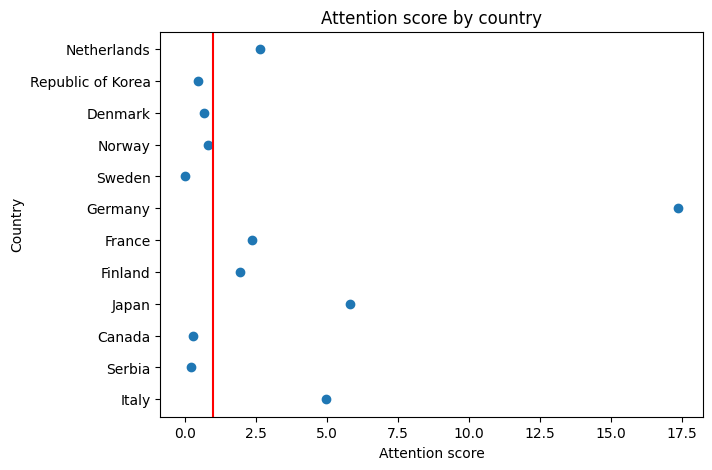

In [46]:
figure = plt.figure(figsize=(7, 5))
plt.scatter(list(attention.values()), list(attention.keys()))
plt.axvline(x=1, color='r')
plt.xlabel("Attention score")
plt.ylabel("Country")
plt.title("Attention score by country")
plt.show()

From the graph above, we can divide the countries into two groups based on the attention score. Countries with a score less than 1 (*low score*) and more than 1 (*high score*). Thus, Korea, Denmark, Norway, Sweden, Canada, and Serbia are 6 countries that experienced lower attention and interest in Covid during their respective pre-lockdown periods. The rest of the countries had higher attention on Covid.

In [47]:
# We set that country with low attention score is labled with 0, otherwise with 1
for country in attention:
    if attention[country] < 1:
        attention[country] = 0
    else:
        attention[country] = 1
        
attention

{'Italy': 1,
 'Serbia': 0,
 'Canada': 0,
 'Japan': 1,
 'Finland': 1,
 'France': 1,
 'Germany': 1,
 'Sweden': 0,
 'Norway': 0,
 'Denmark': 0,
 'Republic of Korea': 0,
 'Netherlands': 1}

## 2. Countries dataset

First, let's get the list of countries that we are analyzing.

In [48]:
countries_list = list(attention.keys())
countries_list

['Italy',
 'Serbia',
 'Canada',
 'Japan',
 'Finland',
 'France',
 'Germany',
 'Sweden',
 'Norway',
 'Denmark',
 'Republic of Korea',
 'Netherlands']

For the second part, we wish to create a dataset that describes each country through a series of different attributes and also describes the situation in the country during the first Covid wave, e.g., the mobility of people, whether there was the official government imposed lockdown or not, etc.

In [49]:
# load apple mobility data
applemobilitytrends = pd.read_csv("data/applemobilitytrends-2020-04-20.csv.gz")
applemobilitytrends.sample(5) 

,geo_type,region,transportation_type,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,...,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20
206,city,Copenhagen,transit,100,98.03,96.54,100.90,113.79,112.37,98.93,...,24.34,25.13,26.58,26.89,28.99,29.29,31.54,28.83,32.50,33.85
84,country/region,Mexico,walking,100,102.15,105.42,107.62,127.85,135.02,87.85,...,30.28,25.26,34.44,34.91,36.02,35.14,39.20,38.20,27.75,35.34
91,country/region,New Zealand,transit,100,97.91,99.45,100.19,94.00,88.77,106.30,...,10.43,11.15,9.79,10.74,9.94,10.75,11.24,11.89,10.74,12.75
67,country/region,Italy,walking,100,102.10,104.86,107.32,122.71,142.38,109.49,...,20.58,11.43,12.05,15.41,17.06,17.77,18.86,19.21,15.37,14.46
311,city,Osaka,walking,100,92.75,98.47,104.44,145.95,154.67,107.12,...,40.19,40.24,56.19,62.21,63.51,58.57,49.10,56.08,50.92,56.66


In [50]:
# Get average mobility data by Apple for each country during observational period (3 weeks until the start of the lockdown). However, we 
# don't wish to look at the mobility data after the lockdown start because when the lockdown starts our observational 
# period begins (Rosenbaum). Thus, for each country, we compute the average mobility within its own observational period. 

# First, get the average mobility for each countries we look at for the each day available
mobility = applemobilitytrends.groupby("region").mean()
mobility = mobility[mobility.index.isin(countries_list)]
mobility

,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,2020-01-21,2020-01-22,...,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20
region,,,,,,,,,,,,,,,,,,,,,
Canada,100.0,103.076667,101.466667,104.940000,118.396667,104.900000,83.583333,102.063333,104.076667,106.910000,...,37.666667,30.240000,34.860000,40.586667,41.433333,42.633333,45.443333,43.116667,35.550000,45.783333
Denmark,100.0,100.356667,102.603333,103.900000,117.776667,113.536667,100.660000,100.506667,102.416667,105.130000,...,56.630000,58.463333,56.496667,59.576667,62.776667,64.630000,68.786667,67.396667,68.646667,70.400000
Finland,100.0,99.303333,101.980000,103.643333,111.566667,111.443333,100.380000,100.483333,101.370000,101.226667,...,60.146667,42.640000,60.830000,57.343333,58.726667,58.126667,66.460000,67.690000,69.680000,70.053333
France,100.0,102.620000,105.213333,110.740000,112.340000,120.483333,88.586667,92.796667,94.000000,96.946667,...,16.196667,13.653333,15.973333,20.413333,20.796667,21.030000,20.886667,17.663333,16.840000,21.520000
Germany,100.0,102.733333,104.136667,106.913333,117.610000,121.310000,99.026667,99.740000,102.170000,101.236667,...,51.620000,50.636667,48.856667,52.626667,56.490000,59.846667,59.220000,56.686667,62.133333,60.163333
Italy,100.0,101.850000,103.556667,104.340000,114.916667,127.720000,109.463333,101.306667,101.746667,103.970000,...,17.283333,10.933333,12.476667,16.160000,17.353333,17.726667,18.243333,17.410000,15.383333,16.376667
Japan,100.0,97.780000,100.770000,106.283333,129.190000,137.006667,105.093333,101.376667,101.930000,99.383333,...,60.813333,57.453333,66.500000,72.043333,70.623333,66.113333,56.176667,67.710000,58.540000,64.116667
Netherlands,100.0,101.686667,103.436667,107.410000,116.410000,119.850000,100.960000,101.393333,104.046667,104.446667,...,45.786667,35.113333,37.360000,41.290000,46.880000,48.436667,49.203333,44.096667,45.140000,46.486667
Norway,100.0,101.143333,103.870000,107.973333,121.870000,127.416667,106.243333,101.843333,103.470000,107.436667,...,44.333333,53.190000,57.790000,59.133333,66.000000,64.430000,68.956667,68.880000,71.123333,74.136667


In [51]:
# observation period for each country
periods = {'Italy': (datetime(2020, 2, 19), datetime(2020, 3, 10)),
 'Serbia': (datetime(2020, 2, 29), datetime(2020, 3, 20)),
 'Canada': (datetime(2020, 2, 22), datetime(2020, 3, 13)),
 'Japan': (datetime(2020, 3, 10), datetime(2020, 3, 30)),
 'Finland': (datetime(2020, 2, 24), datetime(2020, 3, 15)),
 'France': (datetime(2020, 2, 25), datetime(2020, 3, 16)),
 'Germany': (datetime(2020, 3, 1), datetime(2020, 3, 21)),
 'Sweden': (datetime(2020, 2, 19), datetime(2020, 3, 10)),
 'Norway': (datetime(2020, 3, 3), datetime(2020, 3, 23)),
 'Denmark': (datetime(2020, 2, 26), datetime(2020, 3, 17)),
 'Republic of Korea': (datetime(2020, 2, 4), datetime(2020, 2, 24)),
 'Netherlands': (datetime(2020, 2, 24), datetime(2020, 3, 15))}

# get average mobility for each country
average_mobility = {}
for country in countries_list:
    average_mobility[country] = mobility.loc[
        country, periods[country][0].strftime("%Y-%m-%d"): periods[country][1].strftime("%Y-%m-%d")].mean()
    
average_mobility = pd.DataFrame.from_dict(average_mobility, orient='index', columns=['mobility'])
average_mobility

,mobility
Italy,87.094286
Serbia,77.719286
Canada,107.043810
Japan,121.673333
Finland,100.205714
France,90.543810
Germany,87.055556
Sweden,111.287778
Norway,72.583333
Denmark,92.342063


In [52]:
# We load the countries dataset containing the various information about each country
countries = pd.read_csv("data/countries.csv", thousands=',')
countries["Country"] = countries["Country"].apply(lambda x : x.strip())

countries = countries[countries["Country"].isin(countries_list)].dropna(axis=1, how='any')
countries.drop("Region", axis=1, inplace=True)
countries

,Country,Population,Area,Pop_Density,Coastline,Net_migration,Infant_mortality,GDP_per_capita,Literacy,Phones_per_1000,Arable,Crops,Other,Agriculture,Industry,Service
36,Canada,33098932,9984670,33,202,596.0,475.0,29800.0,970.0,5522.0,496.0,2.0,9502.0,22.0,294.0,684.0
54,Denmark,5450661,43094,1265,1697,248.0,456.0,31100.0,1000.0,6146.0,5402.0,19.0,4579.0,18.0,246.0,735.0
68,Finland,5231372,338145,155,37,95.0,357.0,27400.0,1000.0,4053.0,719.0,3.0,9278.0,28.0,295.0,676.0
69,France,60876136,547030,1113,63,66.0,426.0,27600.0,990.0,5864.0,3353.0,207.0,644.0,22.0,214.0,764.0
76,Germany,82422299,357021,2309,67,218.0,416.0,27600.0,990.0,6679.0,3385.0,59.0,6556.0,9.0,296.0,695.0
101,Italy,58133509,301230,1930,252,207.0,594.0,26700.0,986.0,4309.0,2779.0,953.0,6268.0,21.0,291.0,688.0
103,Japan,127463611,377835,3374,787,0.0,326.0,28200.0,990.0,4612.0,1219.0,96.0,8685.0,17.0,258.0,725.0
110,Republic of Korea,48846823,98480,4960,245,0.0,705.0,17800.0,979.0,4861.0,1718.0,195.0,8087.0,33.0,403.0,563.0
146,Netherlands,16491461,41526,3971,109,291.0,504.0,28600.0,990.0,4608.0,2671.0,97.0,7232.0,21.0,244.0,736.0
154,Norway,4610820,323802,142,777,174.0,37.0,37800.0,1000.0,4617.0,287.0,0.0,9713.0,21.0,415.0,564.0


In [53]:
# merging the mobility dataset with countries
countries = countries.merge(average_mobility, left_on="Country", right_index=True)
countries

,Country,Population,Area,Pop_Density,Coastline,Net_migration,Infant_mortality,GDP_per_capita,Literacy,Phones_per_1000,Arable,Crops,Other,Agriculture,Industry,Service,mobility
36,Canada,33098932,9984670,33,202,596.0,475.0,29800.0,970.0,5522.0,496.0,2.0,9502.0,22.0,294.0,684.0,107.043810
54,Denmark,5450661,43094,1265,1697,248.0,456.0,31100.0,1000.0,6146.0,5402.0,19.0,4579.0,18.0,246.0,735.0,92.342063
68,Finland,5231372,338145,155,37,95.0,357.0,27400.0,1000.0,4053.0,719.0,3.0,9278.0,28.0,295.0,676.0,100.205714
69,France,60876136,547030,1113,63,66.0,426.0,27600.0,990.0,5864.0,3353.0,207.0,644.0,22.0,214.0,764.0,90.543810
76,Germany,82422299,357021,2309,67,218.0,416.0,27600.0,990.0,6679.0,3385.0,59.0,6556.0,9.0,296.0,695.0,87.055556
101,Italy,58133509,301230,1930,252,207.0,594.0,26700.0,986.0,4309.0,2779.0,953.0,6268.0,21.0,291.0,688.0,87.094286
103,Japan,127463611,377835,3374,787,0.0,326.0,28200.0,990.0,4612.0,1219.0,96.0,8685.0,17.0,258.0,725.0,121.673333
110,Republic of Korea,48846823,98480,4960,245,0.0,705.0,17800.0,979.0,4861.0,1718.0,195.0,8087.0,33.0,403.0,563.0,76.992381
146,Netherlands,16491461,41526,3971,109,291.0,504.0,28600.0,990.0,4608.0,2671.0,97.0,7232.0,21.0,244.0,736.0,101.570000
154,Norway,4610820,323802,142,777,174.0,37.0,37800.0,1000.0,4617.0,287.0,0.0,9713.0,21.0,415.0,564.0,72.583333


In [54]:
global_mobility = pd.read_csv("data/Global_Mobility_Report.csv")
global_mobility

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2111407,ZW,Zimbabwe,Midlands Province,Kwekwe,NaN,NaN,NaN,2020-08-19,NaN,NaN,NaN,NaN,-9.0,NaN
2111408,ZW,Zimbabwe,Midlands Province,Kwekwe,NaN,NaN,NaN,2020-08-20,NaN,NaN,NaN,NaN,-5.0,NaN
2111409,ZW,Zimbabwe,Midlands Province,Kwekwe,NaN,NaN,NaN,2020-08-21,NaN,NaN,NaN,NaN,-5.0,NaN
2111410,ZW,Zimbabwe,Midlands Province,Kwekwe,NaN,NaN,NaN,2020-08-24,NaN,NaN,NaN,NaN,-4.0,NaN


In [55]:
# load the mobility data from Google f
global_mobility = pd.read_csv("data/Global_Mobility_Report.csv")
global_mobility["date"] = pd.to_datetime(global_mobility["date"])

# get the average mobility change for each country during the pre-lockdown period
average_global_mobility = {}
for country in countries_list:
    if "Republic of Korea":
        # in the global_mobility dataset Republic of Korea is labeled as South Korea
        c = "South Korea"
    else:
        c = country
    # make sure that we only take into account the 3-week pre-lockdown period
    average_global_mobility[country] = global_mobility[(periods[country][0] <= global_mobility["date"]) & 
                                                       (global_mobility["date"] <= periods[country][1]) & 
                                                       (global_mobility['country_region'] == c)].mean()

average_global_mobility = pd.DataFrame.from_dict(average_global_mobility, orient='index', 
                            columns=['retail_and_recreation_percent_change_from_baseline',
                                     'grocery_and_pharmacy_percent_change_from_baseline',
                                     'parks_percent_change_from_baseline',
                                     'transit_stations_percent_change_from_baseline',
                                     'workplaces_percent_change_from_baseline',
                                     'residential_percent_change_from_baseline'])
average_global_mobility

,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
Italy,-25.166667,-6.142857,-1.095238,-20.714286,-7.404762,8.452381
Serbia,-25.523810,-4.476190,9.119048,-21.880952,-8.309524,8.952381
Canada,-27.190476,-6.238095,0.714286,-22.523810,-8.595238,9.238095
Japan,-21.642857,-0.904762,27.976190,-18.166667,-7.404762,7.857143
Finland,-27.214286,-5.071429,2.761905,-22.761905,-8.928571,9.333333
France,-27.119048,-5.404762,3.476190,-22.880952,-8.976190,9.357143
Germany,-24.857143,-3.928571,10.976190,-21.309524,-8.119048,8.761905
Sweden,-25.166667,-6.142857,-1.095238,-20.714286,-7.404762,8.452381
Norway,-23.642857,-3.761905,16.714286,-20.166667,-7.857143,8.476190
Denmark,-26.619048,-5.166667,5.619048,-22.571429,-8.833333,9.214286


In [56]:
# And we merge it with our countries dataset
countries = countries.merge(average_global_mobility, left_on="Country", right_index=True)
countries

,Country,Population,Area,Pop_Density,Coastline,Net_migration,Infant_mortality,GDP_per_capita,Literacy,Phones_per_1000,...,Agriculture,Industry,Service,mobility,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
36,Canada,33098932,9984670,33,202,596.0,475.0,29800.0,970.0,5522.0,...,22.0,294.0,684.0,107.043810,-27.190476,-6.238095,0.714286,-22.523810,-8.595238,9.238095
54,Denmark,5450661,43094,1265,1697,248.0,456.0,31100.0,1000.0,6146.0,...,18.0,246.0,735.0,92.342063,-26.619048,-5.166667,5.619048,-22.571429,-8.833333,9.214286
68,Finland,5231372,338145,155,37,95.0,357.0,27400.0,1000.0,4053.0,...,28.0,295.0,676.0,100.205714,-27.214286,-5.071429,2.761905,-22.761905,-8.928571,9.333333
69,France,60876136,547030,1113,63,66.0,426.0,27600.0,990.0,5864.0,...,22.0,214.0,764.0,90.543810,-27.119048,-5.404762,3.476190,-22.880952,-8.976190,9.357143
76,Germany,82422299,357021,2309,67,218.0,416.0,27600.0,990.0,6679.0,...,9.0,296.0,695.0,87.055556,-24.857143,-3.928571,10.976190,-21.309524,-8.119048,8.761905
101,Italy,58133509,301230,1930,252,207.0,594.0,26700.0,986.0,4309.0,...,21.0,291.0,688.0,87.094286,-25.166667,-6.142857,-1.095238,-20.714286,-7.404762,8.452381
103,Japan,127463611,377835,3374,787,0.0,326.0,28200.0,990.0,4612.0,...,17.0,258.0,725.0,121.673333,-21.642857,-0.904762,27.976190,-18.166667,-7.404762,7.857143
110,Republic of Korea,48846823,98480,4960,245,0.0,705.0,17800.0,979.0,4861.0,...,33.0,403.0,563.0,76.992381,-12.850000,-3.050000,-6.250000,-10.750000,-1.250000,4.650000
146,Netherlands,16491461,41526,3971,109,291.0,504.0,28600.0,990.0,4608.0,...,21.0,244.0,736.0,101.570000,-27.214286,-5.071429,2.761905,-22.761905,-8.928571,9.333333
154,Norway,4610820,323802,142,777,174.0,37.0,37800.0,1000.0,4617.0,...,21.0,415.0,564.0,72.583333,-23.642857,-3.761905,16.714286,-20.166667,-7.857143,8.476190


In [57]:
# Finally, we load the interventions dataset
interventions = pd.read_csv("data/interventions.csv")
interventions

,lang,1st case,1st death,School closure,Public events banned,Lockdown,Mobility,Normalcy
0,fr,2020-01-24,2020-02-14,2020-03-14,2020-03-13,2020-03-17,2020-03-16,2020-07-02
1,da,2020-02-27,2020-03-12,2020-03-13,2020-03-12,2020-03-18,2020-03-11,2020-06-05
2,de,2020-01-27,2020-03-09,2020-03-14,2020-03-22,2020-03-22,2020-03-16,2020-07-10
3,it,2020-01-31,2020-02-22,2020-03-05,2020-03-09,2020-03-11,2020-03-11,2020-06-26
4,nl,2020-02-27,2020-03-06,2020-03-11,2020-03-24,NaN,2020-03-16,2020-05-29
5,no,2020-02-26,2020-02-26,2020-03-13,2020-03-12,2020-03-24,2020-03-11,2020-06-04
6,sr,2020-03-06,2020-03-20,2020-03-15,2020-03-21,2020-03-21,2020-03-16,2020-05-02
7,sv,2020-01-31,2020-03-11,2020-03-18,2020-03-12,NaN,2020-03-11,2020-06-05
8,ko,2020-01-20,2020-02-20,2020-02-23,NaN,NaN,2020-02-25,2020-04-15
9,ca,2020-01-31,2020-02-13,2020-03-12,2020-03-08,2020-03-14,2020-03-16,NaN


In [58]:
# get the flag feature describing whether the country had an offical lockdown: 0 - no, 1 - yes
interventions["had_lockdown"] = interventions["Lockdown"].apply(lambda x : 1 if isinstance(x, str) else 0)
interventions = interventions[["lang", "had_lockdown"]].iloc[:-1]
interventions

,lang,had_lockdown
0,fr,1
1,da,1
2,de,1
3,it,1
4,nl,0
5,no,1
6,sr,1
7,sv,0
8,ko,0
9,ca,1


In [59]:
# create a corresponding Country names column
interventions['Country'] = ["France", "Denmark", "Germany", "Italy", "Netherlands", "Norway", "Serbia", "Sweden", "Republic of Korea", 
                           "Canada", "Finland", "Japan"]
interventions = interventions[["Country", "had_lockdown"]]
interventions

,Country,had_lockdown
0,France,1
1,Denmark,1
2,Germany,1
3,Italy,1
4,Netherlands,0
5,Norway,1
6,Serbia,1
7,Sweden,0
8,Republic of Korea,0
9,Canada,1


In [60]:
# add this flag feature to our countries dataset
countries = countries.merge(interventions, on="Country")
countries.set_index("Country", inplace=True)
countries

,Population,Area,Pop_Density,Coastline,Net_migration,Infant_mortality,GDP_per_capita,Literacy,Phones_per_1000,Arable,...,Industry,Service,mobility,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,had_lockdown
Country,,,,,,,,,,,,,,,,,,,,,
Canada,33098932,9984670,33,202,596.0,475.0,29800.0,970.0,5522.0,496.0,...,294.0,684.0,107.043810,-27.190476,-6.238095,0.714286,-22.523810,-8.595238,9.238095,1
Denmark,5450661,43094,1265,1697,248.0,456.0,31100.0,1000.0,6146.0,5402.0,...,246.0,735.0,92.342063,-26.619048,-5.166667,5.619048,-22.571429,-8.833333,9.214286,1
Finland,5231372,338145,155,37,95.0,357.0,27400.0,1000.0,4053.0,719.0,...,295.0,676.0,100.205714,-27.214286,-5.071429,2.761905,-22.761905,-8.928571,9.333333,0
France,60876136,547030,1113,63,66.0,426.0,27600.0,990.0,5864.0,3353.0,...,214.0,764.0,90.543810,-27.119048,-5.404762,3.476190,-22.880952,-8.976190,9.357143,1
Germany,82422299,357021,2309,67,218.0,416.0,27600.0,990.0,6679.0,3385.0,...,296.0,695.0,87.055556,-24.857143,-3.928571,10.976190,-21.309524,-8.119048,8.761905,1
Italy,58133509,301230,1930,252,207.0,594.0,26700.0,986.0,4309.0,2779.0,...,291.0,688.0,87.094286,-25.166667,-6.142857,-1.095238,-20.714286,-7.404762,8.452381,1
Japan,127463611,377835,3374,787,0.0,326.0,28200.0,990.0,4612.0,1219.0,...,258.0,725.0,121.673333,-21.642857,-0.904762,27.976190,-18.166667,-7.404762,7.857143,0
Republic of Korea,48846823,98480,4960,245,0.0,705.0,17800.0,979.0,4861.0,1718.0,...,403.0,563.0,76.992381,-12.850000,-3.050000,-6.250000,-10.750000,-1.250000,4.650000,0
Netherlands,16491461,41526,3971,109,291.0,504.0,28600.0,990.0,4608.0,2671.0,...,244.0,736.0,101.570000,-27.214286,-5.071429,2.761905,-22.761905,-8.928571,9.333333,0


Finally,we add the final piece of our `countries` dataset, the previously computed attention scores for each country.

In [61]:
countries = countries.merge(pd.DataFrame.from_dict(attention, orient='index', columns=['Attention']), left_index=True, right_index=True)
countries

,Population,Area,Pop_Density,Coastline,Net_migration,Infant_mortality,GDP_per_capita,Literacy,Phones_per_1000,Arable,...,Service,mobility,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,had_lockdown,Attention
Canada,33098932,9984670,33,202,596.0,475.0,29800.0,970.0,5522.0,496.0,...,684.0,107.043810,-27.190476,-6.238095,0.714286,-22.523810,-8.595238,9.238095,1,0
Denmark,5450661,43094,1265,1697,248.0,456.0,31100.0,1000.0,6146.0,5402.0,...,735.0,92.342063,-26.619048,-5.166667,5.619048,-22.571429,-8.833333,9.214286,1,0
Finland,5231372,338145,155,37,95.0,357.0,27400.0,1000.0,4053.0,719.0,...,676.0,100.205714,-27.214286,-5.071429,2.761905,-22.761905,-8.928571,9.333333,0,1
France,60876136,547030,1113,63,66.0,426.0,27600.0,990.0,5864.0,3353.0,...,764.0,90.543810,-27.119048,-5.404762,3.476190,-22.880952,-8.976190,9.357143,1,1
Germany,82422299,357021,2309,67,218.0,416.0,27600.0,990.0,6679.0,3385.0,...,695.0,87.055556,-24.857143,-3.928571,10.976190,-21.309524,-8.119048,8.761905,1,1
Italy,58133509,301230,1930,252,207.0,594.0,26700.0,986.0,4309.0,2779.0,...,688.0,87.094286,-25.166667,-6.142857,-1.095238,-20.714286,-7.404762,8.452381,1,1
Japan,127463611,377835,3374,787,0.0,326.0,28200.0,990.0,4612.0,1219.0,...,725.0,121.673333,-21.642857,-0.904762,27.976190,-18.166667,-7.404762,7.857143,0,1
Republic of Korea,48846823,98480,4960,245,0.0,705.0,17800.0,979.0,4861.0,1718.0,...,563.0,76.992381,-12.850000,-3.050000,-6.250000,-10.750000,-1.250000,4.650000,0,0
Netherlands,16491461,41526,3971,109,291.0,504.0,28600.0,990.0,4608.0,2671.0,...,736.0,101.570000,-27.214286,-5.071429,2.761905,-22.761905,-8.928571,9.333333,0,1
Norway,4610820,323802,142,777,174.0,37.0,37800.0,1000.0,4617.0,287.0,...,564.0,72.583333,-23.642857,-3.761905,16.714286,-20.166667,-7.857143,8.476190,1,0


In [62]:
# all of the features of our countries dataset
countries.columns

Index(['Population', 'Area', 'Pop_Density', 'Coastline', 'Net_migration',
       'Infant_mortality', 'GDP_per_capita', 'Literacy', 'Phones_per_1000',
       'Arable', 'Crops', 'Other', 'Agriculture', 'Industry', 'Service',
       'mobility', 'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline', 'had_lockdown',
       'Attention'],
      dtype='object')

## 3. Add Covid's outcome

Finally, we update our `countries` dataset with the outcomes of the Covid pandemic for each country. We choose to look at the time series for the number of infections/cases per day in proportion to the country's population for period of 45 days starting on the first day of the each country's lockdown. We chose this interval as the effects of Covid’s spread, people’s behavior, and attention given to Covid during the pre-lockdown term are most visible at the beginning of the lockdown when coronavirus reaches its peak before lockdown mitigates its spread. On the other hand, we want to be careful about the length of the period we use for comparison. If it is too long, the influences of various confounders could strongly impact the results, e.g., the strictness of the government measures, competence of the countries when handling crises situations, etc. 

In [63]:
# get the offical data about Covid cases and deaths for each country reported by World Health Organization
covid_per_country = pd.read_csv("data/WHO-COVID-19-global-data.csv")
covid_per_country.head(5)

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-03,AF,Afghanistan,EMRO,0,0,0,0
1,2020-01-04,AF,Afghanistan,EMRO,0,0,0,0
2,2020-01-05,AF,Afghanistan,EMRO,0,0,0,0
3,2020-01-06,AF,Afghanistan,EMRO,0,0,0,0
4,2020-01-07,AF,Afghanistan,EMRO,0,0,0,0


In [64]:
# set the Date_reported feature to be of the datetime type
covid_per_country["Date_reported"] = pd.to_datetime(covid_per_country["Date_reported"])
covid_per_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239133 entries, 0 to 239132
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Date_reported      239133 non-null  datetime64[ns]
 1   Country_code       238124 non-null  object        
 2   Country            239133 non-null  object        
 3   WHO_region         239133 non-null  object        
 4   New_cases          239133 non-null  int64         
 5   Cumulative_cases   239133 non-null  int64         
 6   New_deaths         239133 non-null  int64         
 7   Cumulative_deaths  239133 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 14.6+ MB


In [65]:
# get cumulative number of cases and deaths for the selected countries until the 15th of May, 2020
covid_cummulative = covid_per_country[covid_per_country["Country"].isin(countries_list)].groupby("Country").apply(
    lambda x : x[x["Date_reported"] == datetime(2020, 5, 15)][["Cumulative_cases", "Cumulative_deaths"]])
covid_cummulative["Country"] = [idx[0] for idx in covid_cummulative.index]
covid_cummulative = covid_cummulative.set_index("Country")
covid_cummulative

,Cumulative_cases,Cumulative_deaths
Country,,
Canada,72265,5288
Denmark,10728,541
Finland,6495,296
France,140111,27378
Germany,173706,8892
Italy,223096,31368
Japan,16193,710
Netherlands,43232,5562
Norway,8181,229


In [66]:
# get new number of cases for the selected countries for period of 45 days since the begining of the respective country's lockdown
# each column represents the number of days passed since the begining of lockdown
covid_countries = None
for country, data in covid_per_country[covid_per_country["Country"].isin(countries_list)].groupby("Country"):
    series = {}
    for date, cases in zip(data['Date_reported'], data['New_cases']):
        if date < periods[country][1] or date >= periods[country][1] + timedelta(days=45):
            continue
        series[(date - periods[country][1]).days] = cases / countries.at[country, 'Population']
    
    if covid_countries is None:
        covid_countries = pd.Series(data=series, name=country).to_frame()
    else:
        covid_countries = covid_countries.merge(pd.Series(data=series, name=country), left_index=True, right_index=True)

# 
covid_countries = covid_countries.T
covid_countries

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
Canada,0.000000,1.057436e-06,0.000001,5.136117e-07,1.691897e-06,0.000002,0.000003,0.000004,0.000008,0.000004,...,0.000040,0.000052,5.411051e-05,4.435188e-05,4.338509e-05,6.181468e-05,4.803780e-05,5.338541e-05,5.800791e-05,0.000054
Denmark,0.000014,1.394326e-05,0.000015,1.944718e-05,1.871333e-05,0.000009,0.000011,0.000024,0.000025,0.000028,...,0.000039,0.000037,4.146286e-05,4.238018e-05,3.008809e-05,2.458417e-05,2.183221e-05,3.981169e-05,2.495110e-05,0.000026
Finland,0.000006,1.013119e-05,0.000010,8.984259e-06,1.720390e-05,0.000019,0.000017,0.000017,0.000015,0.000016,...,0.000011,0.000013,2.733509e-05,2.140930e-05,2.370315e-05,2.217392e-05,1.758621e-05,1.452774e-05,1.395427e-05,0.000024
France,0.000015,1.974501e-05,0.000018,2.278397e-05,3.022531e-05,0.000026,0.000030,0.000025,0.000063,0.000040,...,0.000012,0.000034,4.333389e-05,2.973250e-05,2.666069e-05,2.882903e-05,2.524799e-05,6.636426e-06,1.905509e-05,0.000017
Germany,0.000049,4.072927e-05,0.000027,4.527901e-05,5.918301e-05,0.000069,0.000072,0.000073,0.000057,0.000037,...,0.000023,0.000015,8.541378e-06,1.357642e-05,1.777432e-05,1.734967e-05,1.771365e-05,1.113776e-05,7.522236e-06,0.000005
Italy,0.000031,1.680614e-05,0.000040,4.560193e-05,4.381294e-05,0.000060,0.000062,0.000056,0.000061,0.000072,...,0.000054,0.000051,4.587715e-05,6.512595e-05,6.008583e-05,6.005142e-05,5.241383e-05,3.880722e-05,4.694367e-05,0.000058
Japan,0.000001,6.825477e-07,0.000002,2.965552e-06,4.785680e-07,0.000002,0.000003,0.000003,0.000002,0.000003,...,0.000002,0.000001,9.649813e-07,8.551460e-07,6.590116e-07,6.354755e-07,9.335998e-07,4.001142e-07,5.962486e-07,0.000001
Netherlands,0.000013,1.049028e-05,0.000016,1.746358e-05,2.104119e-05,0.000024,0.000032,0.000039,0.000037,0.000034,...,0.000072,0.000062,4.535681e-05,4.341641e-05,4.293131e-05,5.299712e-05,4.881314e-05,3.923242e-05,3.947497e-05,0.000025
Norway,0.000038,3.209841e-05,0.000064,6.788380e-05,6.332930e-05,0.000065,0.000057,0.000036,0.000023,0.000057,...,0.000005,0.000008,1.539856e-05,1.084406e-05,8.458365e-06,8.458365e-06,9.325890e-06,4.988267e-06,9.542771e-06,0.000010
Republic of Korea,0.000004,2.661381e-06,0.000005,9.192000e-06,8.741613e-06,0.000019,0.000012,0.000014,0.000012,0.000011,...,0.000002,0.000003,2.067688e-06,1.822022e-06,1.760606e-06,1.924383e-06,1.658245e-06,9.621915e-07,9.621915e-07,0.000001


In [67]:
# merge the covid_countries dataset with our countries dataset
countries = countries.merge(covid_countries, left_index=True, right_index=True)
countries = countries.merge(covid_cummulative, left_index=True, right_index=True)
countries

,Population,Area,Pop_Density,Coastline,Net_migration,Infant_mortality,GDP_per_capita,Literacy,Phones_per_1000,Arable,...,37,38,39,40,41,42,43,44,Cumulative_cases,Cumulative_deaths
Canada,33098932,9984670,33,202,596.0,475.0,29800.0,970.0,5522.0,496.0,...,5.411051e-05,4.435188e-05,4.338509e-05,6.181468e-05,4.803780e-05,5.338541e-05,5.800791e-05,0.000054,72265,5288
Denmark,5450661,43094,1265,1697,248.0,456.0,31100.0,1000.0,6146.0,5402.0,...,4.146286e-05,4.238018e-05,3.008809e-05,2.458417e-05,2.183221e-05,3.981169e-05,2.495110e-05,0.000026,10728,541
Finland,5231372,338145,155,37,95.0,357.0,27400.0,1000.0,4053.0,719.0,...,2.733509e-05,2.140930e-05,2.370315e-05,2.217392e-05,1.758621e-05,1.452774e-05,1.395427e-05,0.000024,6495,296
France,60876136,547030,1113,63,66.0,426.0,27600.0,990.0,5864.0,3353.0,...,4.333389e-05,2.973250e-05,2.666069e-05,2.882903e-05,2.524799e-05,6.636426e-06,1.905509e-05,0.000017,140111,27378
Germany,82422299,357021,2309,67,218.0,416.0,27600.0,990.0,6679.0,3385.0,...,8.541378e-06,1.357642e-05,1.777432e-05,1.734967e-05,1.771365e-05,1.113776e-05,7.522236e-06,0.000005,173706,8892
Italy,58133509,301230,1930,252,207.0,594.0,26700.0,986.0,4309.0,2779.0,...,4.587715e-05,6.512595e-05,6.008583e-05,6.005142e-05,5.241383e-05,3.880722e-05,4.694367e-05,0.000058,223096,31368
Japan,127463611,377835,3374,787,0.0,326.0,28200.0,990.0,4612.0,1219.0,...,9.649813e-07,8.551460e-07,6.590116e-07,6.354755e-07,9.335998e-07,4.001142e-07,5.962486e-07,0.000001,16193,710
Republic of Korea,48846823,98480,4960,245,0.0,705.0,17800.0,979.0,4861.0,1718.0,...,2.067688e-06,1.822022e-06,1.760606e-06,1.924383e-06,1.658245e-06,9.621915e-07,9.621915e-07,0.000001,11018,260
Netherlands,16491461,41526,3971,109,291.0,504.0,28600.0,990.0,4608.0,2671.0,...,4.535681e-05,4.341641e-05,4.293131e-05,5.299712e-05,4.881314e-05,3.923242e-05,3.947497e-05,0.000025,43232,5562
Norway,4610820,323802,142,777,174.0,37.0,37800.0,1000.0,4617.0,287.0,...,1.539856e-05,1.084406e-05,8.458365e-06,8.458365e-06,9.325890e-06,4.988267e-06,9.542771e-06,0.000010,8181,229


In [68]:
# Let's normalize the cumulative cases and deaths
countries["Cumulative_cases"] /= countries['Population']
countries["Cumulative_deaths"] /= countries['Population']
countries

,Population,Area,Pop_Density,Coastline,Net_migration,Infant_mortality,GDP_per_capita,Literacy,Phones_per_1000,Arable,...,37,38,39,40,41,42,43,44,Cumulative_cases,Cumulative_deaths
Canada,33098932,9984670,33,202,596.0,475.0,29800.0,970.0,5522.0,496.0,...,5.411051e-05,4.435188e-05,4.338509e-05,6.181468e-05,4.803780e-05,5.338541e-05,5.800791e-05,0.000054,0.002183,0.000160
Denmark,5450661,43094,1265,1697,248.0,456.0,31100.0,1000.0,6146.0,5402.0,...,4.146286e-05,4.238018e-05,3.008809e-05,2.458417e-05,2.183221e-05,3.981169e-05,2.495110e-05,0.000026,0.001968,0.000099
Finland,5231372,338145,155,37,95.0,357.0,27400.0,1000.0,4053.0,719.0,...,2.733509e-05,2.140930e-05,2.370315e-05,2.217392e-05,1.758621e-05,1.452774e-05,1.395427e-05,0.000024,0.001242,0.000057
France,60876136,547030,1113,63,66.0,426.0,27600.0,990.0,5864.0,3353.0,...,4.333389e-05,2.973250e-05,2.666069e-05,2.882903e-05,2.524799e-05,6.636426e-06,1.905509e-05,0.000017,0.002302,0.000450
Germany,82422299,357021,2309,67,218.0,416.0,27600.0,990.0,6679.0,3385.0,...,8.541378e-06,1.357642e-05,1.777432e-05,1.734967e-05,1.771365e-05,1.113776e-05,7.522236e-06,0.000005,0.002108,0.000108
Italy,58133509,301230,1930,252,207.0,594.0,26700.0,986.0,4309.0,2779.0,...,4.587715e-05,6.512595e-05,6.008583e-05,6.005142e-05,5.241383e-05,3.880722e-05,4.694367e-05,0.000058,0.003838,0.000540
Japan,127463611,377835,3374,787,0.0,326.0,28200.0,990.0,4612.0,1219.0,...,9.649813e-07,8.551460e-07,6.590116e-07,6.354755e-07,9.335998e-07,4.001142e-07,5.962486e-07,0.000001,0.000127,0.000006
Republic of Korea,48846823,98480,4960,245,0.0,705.0,17800.0,979.0,4861.0,1718.0,...,2.067688e-06,1.822022e-06,1.760606e-06,1.924383e-06,1.658245e-06,9.621915e-07,9.621915e-07,0.000001,0.000226,0.000005
Netherlands,16491461,41526,3971,109,291.0,504.0,28600.0,990.0,4608.0,2671.0,...,4.535681e-05,4.341641e-05,4.293131e-05,5.299712e-05,4.881314e-05,3.923242e-05,3.947497e-05,0.000025,0.002621,0.000337
Norway,4610820,323802,142,777,174.0,37.0,37800.0,1000.0,4617.0,287.0,...,1.539856e-05,1.084406e-05,8.458365e-06,8.458365e-06,9.325890e-06,4.988267e-06,9.542771e-06,0.000010,0.001774,0.000050


## 4. Match pairs of similar countries with different Covid attention

The main purpose of this part is to help us match the similar countries based on the features we have gathered, so we can see if there is a difference in how did country do during the first Covid wave.

In [69]:
countries["Country"] = countries.index
countries = countries[["Country"] + list(countries.columns[:-1])]
countries.reset_index(inplace=True, drop=True)
countries

,Country,Population,Area,Pop_Density,Coastline,Net_migration,Infant_mortality,GDP_per_capita,Literacy,Phones_per_1000,...,37,38,39,40,41,42,43,44,Cumulative_cases,Cumulative_deaths
0,Canada,33098932,9984670,33,202,596.0,475.0,29800.0,970.0,5522.0,...,5.411051e-05,4.435188e-05,4.338509e-05,6.181468e-05,4.803780e-05,5.338541e-05,5.800791e-05,0.000054,0.002183,0.000160
1,Denmark,5450661,43094,1265,1697,248.0,456.0,31100.0,1000.0,6146.0,...,4.146286e-05,4.238018e-05,3.008809e-05,2.458417e-05,2.183221e-05,3.981169e-05,2.495110e-05,0.000026,0.001968,0.000099
2,Finland,5231372,338145,155,37,95.0,357.0,27400.0,1000.0,4053.0,...,2.733509e-05,2.140930e-05,2.370315e-05,2.217392e-05,1.758621e-05,1.452774e-05,1.395427e-05,0.000024,0.001242,0.000057
3,France,60876136,547030,1113,63,66.0,426.0,27600.0,990.0,5864.0,...,4.333389e-05,2.973250e-05,2.666069e-05,2.882903e-05,2.524799e-05,6.636426e-06,1.905509e-05,0.000017,0.002302,0.000450
4,Germany,82422299,357021,2309,67,218.0,416.0,27600.0,990.0,6679.0,...,8.541378e-06,1.357642e-05,1.777432e-05,1.734967e-05,1.771365e-05,1.113776e-05,7.522236e-06,0.000005,0.002108,0.000108
5,Italy,58133509,301230,1930,252,207.0,594.0,26700.0,986.0,4309.0,...,4.587715e-05,6.512595e-05,6.008583e-05,6.005142e-05,5.241383e-05,3.880722e-05,4.694367e-05,0.000058,0.003838,0.000540
6,Japan,127463611,377835,3374,787,0.0,326.0,28200.0,990.0,4612.0,...,9.649813e-07,8.551460e-07,6.590116e-07,6.354755e-07,9.335998e-07,4.001142e-07,5.962486e-07,0.000001,0.000127,0.000006
7,Republic of Korea,48846823,98480,4960,245,0.0,705.0,17800.0,979.0,4861.0,...,2.067688e-06,1.822022e-06,1.760606e-06,1.924383e-06,1.658245e-06,9.621915e-07,9.621915e-07,0.000001,0.000226,0.000005
8,Netherlands,16491461,41526,3971,109,291.0,504.0,28600.0,990.0,4608.0,...,4.535681e-05,4.341641e-05,4.293131e-05,5.299712e-05,4.881314e-05,3.923242e-05,3.947497e-05,0.000025,0.002621,0.000337
9,Norway,4610820,323802,142,777,174.0,37.0,37800.0,1000.0,4617.0,...,1.539856e-05,1.084406e-05,8.458365e-06,8.458365e-06,9.325890e-06,4.988267e-06,9.542771e-06,0.000010,0.001774,0.000050


In order to make features, and first of all differences between features comparable with each other, we normalize them using the `min-max` normalization.

In [70]:
# min-max normalization
features = ['Population', 'Area', 'Pop_Density', 'Coastline', 'Net_migration',
       'Infant_mortality', 'GDP_per_capita', 'Literacy', 'Phones_per_1000',
       'Arable', 'Crops', 'Other', 'Agriculture', 'Industry', 'Service',
       'mobility', 'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline']

for column in features:
    countries[column] = (countries[column] - countries[column].min()) / (countries[column].max() - countries[column].min())
    
countries

,Country,Population,Area,Pop_Density,Coastline,Net_migration,Infant_mortality,GDP_per_capita,Literacy,Phones_per_1000,...,37,38,39,40,41,42,43,44,Cumulative_cases,Cumulative_deaths
0,Canada,0.231888,1.000000,0.000000,0.119034,1.000000,0.349840,0.775281,0.571429,0.620690,...,5.411051e-05,4.435188e-05,4.338509e-05,6.181468e-05,4.803780e-05,5.338541e-05,5.800791e-05,0.000054,0.002183,0.000160
1,Denmark,0.006836,0.000158,0.250051,1.000000,0.522634,0.334665,0.811798,1.000000,0.766076,...,4.146286e-05,4.238018e-05,3.008809e-05,2.458417e-05,2.183221e-05,3.981169e-05,2.495110e-05,0.000026,0.001968,0.000099
2,Finland,0.005051,0.029832,0.024762,0.021803,0.312757,0.255591,0.707865,1.000000,0.278425,...,2.733509e-05,2.140930e-05,2.370315e-05,2.217392e-05,1.758621e-05,1.452774e-05,1.395427e-05,0.000024,0.001242,0.000057
3,France,0.457990,0.050839,0.219200,0.037124,0.272977,0.310703,0.713483,0.857143,0.700373,...,4.333389e-05,2.973250e-05,2.666069e-05,2.882903e-05,2.524799e-05,6.636426e-06,1.905509e-05,0.000017,0.002302,0.000450
4,Germany,0.633372,0.031730,0.461944,0.039481,0.481481,0.302716,0.713483,0.857143,0.890261,...,8.541378e-06,1.357642e-05,1.777432e-05,1.734967e-05,1.771365e-05,1.113776e-05,7.522236e-06,0.000005,0.002108,0.000108
5,Italy,0.435665,0.026119,0.385021,0.148497,0.466392,0.444888,0.688202,0.800000,0.338071,...,4.587715e-05,6.512595e-05,6.008583e-05,6.005142e-05,5.241383e-05,3.880722e-05,4.694367e-05,0.000058,0.003838,0.000540
6,Japan,1.000000,0.033823,0.678100,0.463760,0.182442,0.230831,0.730337,0.857143,0.408667,...,9.649813e-07,8.551460e-07,6.590116e-07,6.354755e-07,9.335998e-07,4.001142e-07,5.962486e-07,0.000001,0.000127,0.000006
7,Republic of Korea,0.360073,0.005728,1.000000,0.144372,0.182442,0.533546,0.438202,0.700000,0.466682,...,2.067688e-06,1.822022e-06,1.760606e-06,1.924383e-06,1.658245e-06,9.621915e-07,9.621915e-07,0.000001,0.000226,0.000005
8,Netherlands,0.096706,0.000000,0.799269,0.064231,0.581619,0.373003,0.741573,0.857143,0.407735,...,4.535681e-05,4.341641e-05,4.293131e-05,5.299712e-05,4.881314e-05,3.923242e-05,3.947497e-05,0.000025,0.002621,0.000337
9,Norway,0.000000,0.028389,0.022123,0.457867,0.421125,0.000000,1.000000,1.000000,0.409832,...,1.539856e-05,1.084406e-05,8.458365e-06,8.458365e-06,9.325890e-06,4.988267e-06,9.542771e-06,0.000010,0.001774,0.000050


The feature `had_lockdown` is the only categorical feature, we have in our `countries` dataset. It seems logical when want to compare the spread of Covid between two countries to restrict our matching of countries to only pairs where countries would have both imposed official lockdowns or both didn't.

In [71]:
# separate data to high and low attention countries
high_attention = countries[countries["Attention"] == 1]
low_attention = countries[countries["Attention"] == 0]

# merge low and high attention countries based on 'had_lockdown' feature. 
pairs = pd.merge(high_attention, low_attention, how='inner', on=['had_lockdown'],
                         suffixes=['_high','_low'])

pairs[["Country_high", "Country_low"]]

,Country_high,Country_low
0,Finland,Republic of Korea
1,Finland,Sweden
2,Japan,Republic of Korea
3,Japan,Sweden
4,Netherlands,Republic of Korea
5,Netherlands,Sweden
6,France,Canada
7,France,Denmark
8,France,Norway
9,France,Serbia


We have potentially 18 pairs of countries. We wish to find for each of these pairs how similar the two countries are in order to know if we can compare them. To compute how similar two countries are, we use the following formula:

$$
\text{similarity}(x_1, x_2) = 1 - \frac{1}{N}\sum_{x^i_1, x^i_2}{|x^i_1 - x^i_2|} 
$$

where $x^i_j$, $j\in\{0, 1\}$ is the $i$-th feature of the $j$-th country in the pair.

In [72]:
def similarity_score(pair, features):
    dist = np.mean([abs(pair[feature + '_high'] - pair[feature + '_low']) for feature in features])
    return 1 - dist


features = ['Pop_Density', 'Coastline', 'Net_migration',
       'Infant_mortality', 'GDP_per_capita', 'Literacy', 'Phones_per_1000',
       'Agriculture', 'Industry', 'Service',
       'mobility', 'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline']

print(f"{'High attention':15} <-> {'':4} Low attention")
print('-' * 53)
for _, pair in pairs.iterrows():
    # compute the similarity score between two countries
    print(f"{pair['Country_high']:15} <-> {'':4} {pair['Country_low']:20}: {similarity_score(pair, features):.2f}")

High attention  <->      Low attention
-----------------------------------------------------
Finland         <->      Republic of Korea   : 0.50
Finland         <->      Sweden              : 0.84
Japan           <->      Republic of Korea   : 0.52
Japan           <->      Sweden              : 0.72
Netherlands     <->      Republic of Korea   : 0.52
Netherlands     <->      Sweden              : 0.80
France          <->      Canada              : 0.83
France          <->      Denmark             : 0.87
France          <->      Norway              : 0.67
France          <->      Serbia              : 0.63
Germany         <->      Canada              : 0.80
Germany         <->      Denmark             : 0.82
Germany         <->      Norway              : 0.75
Germany         <->      Serbia              : 0.63
Italy           <->      Canada              : 0.84
Italy           <->      Denmark             : 0.80
Italy           <->      Norway              : 0.74
Italy           <->    

Hence, to determine which pairs we are going to keep for matching, we use both general knowledge and what we learned about the selected countries from previous parts in combination with the similarity scores we designed.

Taking into account all the aforementioned factors, it seems safe to keep all the pairs that have similarity scores of 0.8 or above. In addition, based on the results of previous parts of the project and what we know about these countries, the next "best" pair (Germany, Norway) with a similarity of 0.75, also seems like a valid one.

In [73]:
# matched pairs of countries 
matching = {('Finland', 'Sweden'), ('Netherlands', 'Sweden'), ('France', 'Canada'), 
           ('France', 'Denmark'), ('Germany', 'Canada'), ('Germany', 'Denmark'),
           ('Italy', 'Canada'), ('Italy', 'Denmark'), ('Germany', 'Norway')}

# 5. Analysis

Now, when we matched countries into pairs, we can compare their daily number of new infections (infection rate per day) for the first 45 days of their respective lockdowns to check if there exists a statistically significant difference between paired countries. To do this, we will apply both paired t-test analyses and compute the confidence intervals for the given timeseries. Thus, let's first adjust the significance level with respect to the number of pairs we formed using the Bonferroni principle.

In [74]:
alpha = 0.05
k = len(matching) # number of tests
num_samples = 1000

# following the definition from the lecture 4.
alphaBonferroni = alpha / k

print("Adjusted significance level:", alphaBonferroni)

Adjusted significance level: 0.005555555555555556


Next, we can apply paired t-test for all pairs independently.

In [75]:
high_attention_countries = set(high_attention["Country"])
low_attention_countries = set(low_attention["Country"])

for match in matching:
    # for easier analysis, put the country that has high attention 
    # to be the first one in the pair
    if match[0] in high_attention_countries:
        high_country, low_country = match[0], match[1]        
        high_country_cases = countries[countries["Country"] == match[0]].loc[:, 0:44]
        low_country_cases = countries[countries["Country"] == match[1]].loc[:, 0:44]
    else:
        high_country, low_country = match[1], match[0]
        low_country_cases = countries[countries["Country"] == match[0]].loc[:, 0:44]
        high_country_cases = countries[countries["Country"] == match[1]].loc[:, 0:44]
    
    print("High attention:", high_country, "<->", "Low attention:", low_country)
    print(high_country, "average new cases per day:", high_country_cases.to_numpy()[0].mean())
    print(low_country, "average new cases per day:", low_country_cases.to_numpy()[0].mean())
    
    # apply paired t-test
    print(stats.ttest_rel(high_country_cases.to_numpy()[0], low_country_cases.to_numpy()[0]))
    print('=' * 100)
    print()

High attention: Netherlands <-> Low attention: Sweden
Netherlands average new cases per day: 5.019971648762148e-05
Sweden average new cases per day: 3.858070902441084e-05
Ttest_relResult(statistic=3.1816078190867394, pvalue=0.0026856392322195215)

High attention: Germany <-> Low attention: Norway
Germany average new cases per day: 3.881608678630902e-05
Norway average new cases per day: 2.584259536385188e-05
Ttest_relResult(statistic=4.626293465028069, pvalue=3.277209912961615e-05)

High attention: France <-> Low attention: Canada
France average new cases per day: 4.4170200143963e-05
Canada average new cases per day: 2.9389333636370968e-05
Ttest_relResult(statistic=3.048160007216246, pvalue=0.0038868317304252063)

High attention: France <-> Low attention: Denmark
France average new cases per day: 4.4170200143963e-05
Denmark average new cases per day: 3.429145769863712e-05
Ttest_relResult(statistic=2.6285386131084727, pvalue=0.011764840968114957)

High attention: Finland <-> Low attentio

Looking at the obtained results, we see that except for the (Germany, Canada), (France, Denmark), and (Germany, Denmark) pairs, we can reject the null hypothesis, i.e., there is statistical evidence that there is a difference between means of the number of new infections per day between countries for the observed period. Additionally, we can see that for only (Finland, Sweden) pair, the country with lower attention (Sweden)  has a higher infection rate per day. For all other pairs, it is the other way around, the country with higher attention has a higher rate.

Let's compute the CI-95% for these pairs to confirm these results.

In [76]:
def two_fold_bootstrap_CI(data1, data2, nbr_draws, alpha):
    """
    Twofold bootstrapping function to obtain 95% confidence
    
    Arguments:
        col1: first array of values
        col2: second array of values
        nbr_draws: the number of random samples
        alpha: significant level
    
    Returns:
        CI : [lower error, upper error]
    """
    means = np.zeros(nbr_draws)
    data1 = np.array(data1)
    data2 = np.array(data2)
    
    sample_size1 = len(data1)
    sample_size2 = len(data2)
    for n in range(nbr_draws):
        data1_tmp = np.random.choice(data1, replace=True, size=sample_size1)
        data2_tmp = np.random.choice(data2, replace=True, size=sample_size2)
        
        means[n] = (np.nanmean(data1_tmp) - np.nanmean(data2_tmp))

    return [round(np.nanpercentile(means, alpha * 100 / 2), 6), 
            round(np.nanpercentile(means, 100 - alpha * 100 / 2), 6)]

In [77]:
high_attention_countries = set(high_attention["Country"])
low_attention_countries = set(low_attention["Country"])

for match in matching:
    if match[0] in high_attention_countries:
        high_country, low_country = match[0], match[1]        
        high_country_cases = countries[countries["Country"] == match[0]].loc[:, 0:44]
        low_country_cases = countries[countries["Country"] == match[1]].loc[:, 0:44]
    else:
        high_country, low_country = match[1], match[0]
        low_country_cases = countries[countries["Country"] == match[0]].loc[:, 0:44]
        high_country_cases = countries[countries["Country"] == match[1]].loc[:, 0:44]
    
    print("High attention", high_country, "<->", "Low attention:", low_country)
    print(high_country, "average new cases per day:", high_country_cases.to_numpy()[0].mean())
    print(low_country, "average new cases per day:", low_country_cases.to_numpy()[0].mean())
    print("CI-95%:", two_fold_bootstrap_CI(high_country_cases.to_numpy()[0], low_country_cases.to_numpy()[0], num_samples, alphaBonferroni))
    print('=' * 100)
    print()

High attention Netherlands <-> Low attention: Sweden
Netherlands average new cases per day: 5.019971648762148e-05
Sweden average new cases per day: 3.858070902441084e-05
CI-95%: [1e-06, 2.3e-05]

High attention Germany <-> Low attention: Norway
Germany average new cases per day: 3.881608678630902e-05
Norway average new cases per day: 2.584259536385188e-05
CI-95%: [1e-06, 2.3e-05]

High attention France <-> Low attention: Canada
France average new cases per day: 4.4170200143963e-05
Canada average new cases per day: 2.9389333636370968e-05
CI-95%: [3e-06, 2.9e-05]

High attention France <-> Low attention: Denmark
France average new cases per day: 4.4170200143963e-05
Denmark average new cases per day: 3.429145769863712e-05
CI-95%: [-2e-06, 2.3e-05]

High attention Finland <-> Low attention: Sweden
Finland average new cases per day: 2.0432286002388835e-05
Sweden average new cases per day: 3.858070902441084e-05
CI-95%: [-2.8e-05, -1e-05]

High attention Germany <-> Low attention: Canada
Germ

We can see that for the (Germany, Norway), (France, Canada), (Italy, Denmark), and (Italy, Canada) pairs, the CI-95% are fully positive which means that countries with higher attention in the pairs (Germany, France, Italy) had higher infection rates compared to their lower attention pairs. Only (Finland, Sweden) pair has a fully negative CI-95%, meaning Finland with higher attention did better than Sweden with lower attention. Hence, we can say that these results correspond to ones obtained by paired t-tests.

We now wish to aggregate the results for low and high-attention countries and perform a paired t-test to see if there exists a statistical difference between mean infection rates of low and high-attention countries.

In [78]:
new_cases_aggregated_high = countries[countries["Country"].isin(
    set([i[0] for i in list(matching)]))].loc[:, 0:44].mean(axis=0)
new_cases_aggregated_low = countries[countries["Country"].isin(
    set([i[1] for i in list(matching)]))].loc[:, 0:44].mean(axis=0)

print("High-attention countries average new cases per day:", new_cases_aggregated_high.to_numpy().mean())
print("Low-attention countries average new cases per day:", new_cases_aggregated_low.to_numpy().mean())
print(stats.ttest_rel(new_cases_aggregated_high.to_numpy(), new_cases_aggregated_low.to_numpy(), alternative='greater'))

High-attention countries average new cases per day: 4.4481414476156673e-05
Low-attention countries average new cases per day: 3.2026023930817703e-05
Ttest_relResult(statistic=5.522130530645776, pvalue=8.457495388894413e-07)


The paired t-test suggests that we can reject the null hypothesis as the p-value is essentially zero, hence there is statistical evidence that there exists a difference between infection rates of low and high-attention countries. As high-attention countries have bigger average new cases per day than low-attention ones, we can infer that countries with low attention in their respective pre-lockdown periods, did better on average during the first Covid wave.

# Conclusions

Results that we obtained from paired t-tests and confidence intervals suggest that in most of the cases, countries with more attention towards Covid at the early stages of the pandemic had more daily infections proportionally to their population than those with less attention. Thus, we can hypothesize that speaking about Covid and giving it a lot of interest and attention was not the way to fight Covid at the early stages of the pandemic, but it was a natural reaction of the population caused by the fast spread of this virus in a country. In other words, it could happen that people talked and searched about Covid more because of the general fear and panic of its fast spreading to try to find a way to protect themselves, and not to warn about it and prevent its spread. Hence in that case, we would have countries where Covid was not seen as an immediate treatment and simply did not get the same level of treatment (at least not at the beginning) there.

However, we do have to emphasize that there could be many potential confounders that we cannot observe or quantify and that influence the results quite significantly. For instance, the mentality of the people of a country could be an interesting such confounder (people of some countries tend to be more rebellious towards government's instructions than others, leaner to panic in a crisis, etc.). In addition, the results we got are a direct consequence of the parameters and data that we set and obtained manually. Although we tried to balance data gathered from Twitter as much as possible, it could happen that the results we have do not reflect the level of attention that was realistically given to Covid, or simply Twitter is not a reliable source to determine the topics talked about in particular countries.  Finally, changing parameters like the length of the observation periods for finding attention and comparing Covid spread rates may result in some different findings.